# Test of SciNet with a force pendulum

### Creation of synthetic data for force pendulum + damping + little angles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from tqdm import tqdm

import gc

from physical_parameters_SciNet.model_instances.n1_setting_synthetic_forced_damped_pendulum import config



Choosen device = cuda


#### One damped forced pendulum with a constant forcing

In [2]:
def create_synthetic_damped_forced_pendulum(A: float, omega: float, beta: float, kapa: float, theta0: float, omega0: float, t: np.ndarray) -> np.ndarray:
    """
    Create synthetic data for a damped forced pendulum with small angle approximation.

    Parameters:
    A (float): Amplitude of the forcing term.
    omega (float): Frequency of the forcing term.
    beta (float): Damping coefficient. Corresponds to 'b/L' in the equation.
    kapa (float): Spring constant of the pendulum. Corresponds to 'g/L' in the equation.
    theta0 (float): Initial angle (in radians).
    omega0 (float): Initial angular velocity (in radians per second).
    t (numpy array): Time array.

    Returns:
    numpy array: Array of angles at each time step.
    """

    def pendulum_ode(t, y):
        theta, omega_t = y
        dtheta_dt = omega_t
        domega_dt = - beta * omega_t - kapa * theta + A * np.cos(omega * t)
        return [dtheta_dt, domega_dt]

    y0 = [theta0, omega0]
    sol = solve_ivp(pendulum_ode, [t[0], t[-1]], y0, t_eval=t)
    
    return sol.y[0]  # Return only the angle array

In [3]:
A = 1.0
omega = 3.0
beta = 0.2
kapa = 3.0
theta0 = 0.9  # Initial angle in radians
omega0 = 0.0  # Initial angular velocity
t = np.linspace(0, 100, 10000)  # Time from 0 to 10 seconds

y = create_synthetic_damped_forced_pendulum(A, omega, beta, kapa, theta0, omega0, t)

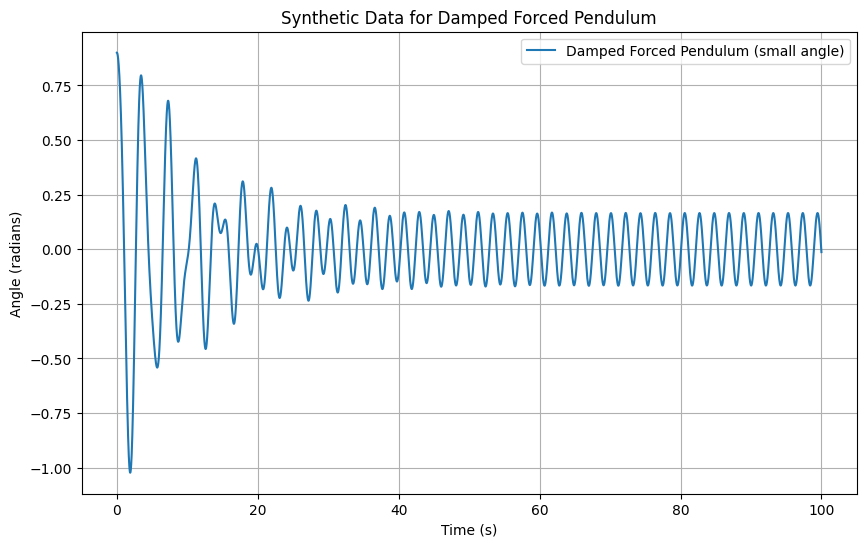

In [4]:
fig = plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Damped Forced Pendulum (small angle)')
plt.title('Synthetic Data for Damped Forced Pendulum')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.legend()
plt.grid()
plt.show()

#### Create complexe profil of forcing

-> trapezoidale shape

In [5]:
def create_trapezoidal_forcing(t: np.ndarray, start_value: float, end_value: float, proportions: list[float], N_time_steps: int) -> np.ndarray:
    """
    Create a trapezoidal forcing function.

    Args:
        t (numpy array): Time array.
        start_value (float): Initial value of the forcing.
        end_value (float): Value at the plateau of the trapezoid.
        proportions (list): List of 4 proportions [p1, p2, p3, p4] defining:
                        - from 0 to p1: constant value at start_value
                        - from p1 to p2: linear rise from start_value to end_value
                        - from p2 to p3: plateau at end_value
                        - from p3 to p4: linear fall from end_value to start_value
                        - from p4 to 1: constant value at start_value
        N_time_steps (int): Number of time steps. Theoretically len(t).

    Returns:
        array: Array of the trapezoidal forcing function.
    """
    assert len(t) == N_time_steps, "Length of time array must match N_time_steps"
    if len(proportions) != 4:
        raise ValueError("proportions must be a list of 4 values")

    p1, p2, p3, p4 = proportions
    if not (0 <= p1 <= p2 <= p3 <= p4 <= 1):
        raise ValueError("Proportions must be increasing and between 0 and 1")

    # Transition indices
    idx1 = int(p1 * N_time_steps)
    idx2 = int(p2 * N_time_steps)
    idx3 = int(p3 * N_time_steps)
    idx4 = int(p4 * N_time_steps)

    # Initialize the array
    omega_array = np.ones(N_time_steps) * start_value

    # Phase 1: Linear rise (p1 to p2)
    if idx2 > idx1:
        slope_up = (end_value - start_value) / (t[idx2] - t[idx1])
        omega_array[idx1:idx2] = start_value + slope_up * (t[idx1:idx2] - t[idx1])

    # Phase 2: Plateau (p2 to p3)
    omega_array[idx2:idx3] = end_value

    # Phase 3: Linear fall (p3 to p4)
    if idx4 > idx3:
        slope_down = (start_value - end_value) / (t[idx4] - t[idx3])
        omega_array[idx3:idx4] = end_value + slope_down * (t[idx3:idx4] - t[idx3])
    
    return omega_array

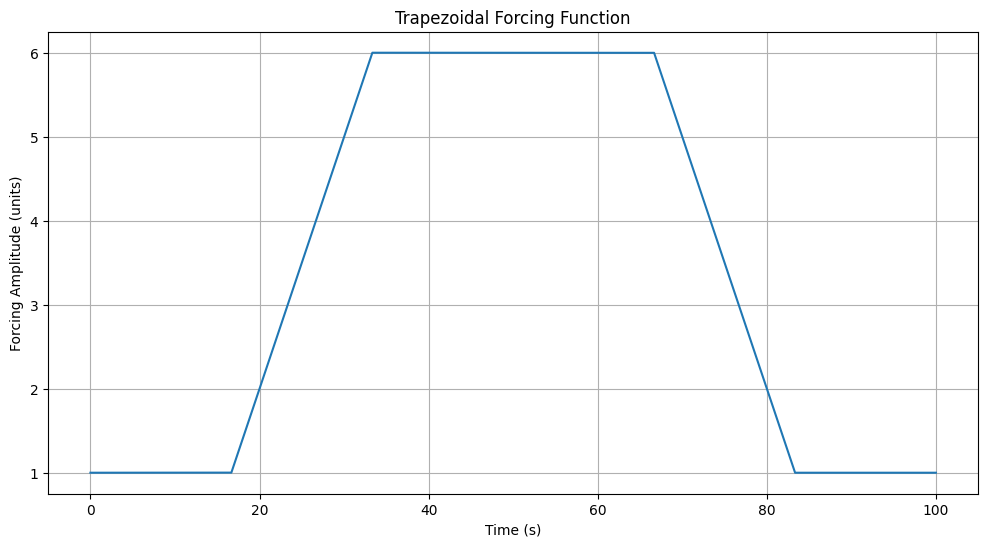

In [6]:
N_time_steps = 100000
t = np.linspace(0, 100, N_time_steps)

omega_array = create_trapezoidal_forcing(
    t=t,
    start_value=1.0,
    end_value=6.0,
    proportions=[1/6, 1/3, 2/3, 5/6],
    N_time_steps=N_time_steps
)

plt.figure(figsize=(12, 6))
plt.plot(t, omega_array)
plt.xlabel('Time (s)')
plt.ylabel('Forcing Amplitude (units)')
plt.title('Trapezoidal Forcing Function')
plt.grid(True)
plt.show()

#### Create pendulum with trapezoidal forcing

In [7]:
def create_synthetic_damped_forced_pendulum(A_array: np.ndarray, omega_array: np.ndarray, beta: float, kapa: float, theta0: float, omega0: float, t: np.ndarray) -> np.ndarray:
    """
    Create synthetic data for a damped forced pendulum with small angle approximation
    and time-varying forcing frequency.

    Args:
        A (numpy array): Amplitude of the forcing term (time-varying).
        omega_array (numpy array): Array of forcing frequencies at each time step.
        beta (float): Damping coefficient. Corresponds to 'b/L' in the equation.
        kapa (float): Spring constant of the pendulum. Corresponds to 'g/L' in the equation.
        theta0 (float): Initial angle (in radians).
        omega0 (float): Initial angular velocity (in radians per second).
        t (numpy array): Time array.

    Returns:
        numpy array: Array of angles at each time step.
    """
    # Check if omega_array has the same length as t
    if len(omega_array) != len(t):
        raise ValueError("omega_array must have the same length as t")
    # Check if A is constant or variable
    if len(A_array) != len(t):
        raise ValueError("If A is an array, it must have the same length as t")


    def pendulum_ode(t, y):
        # Find the index of the current time step
        idx = np.abs(t_array - t).argmin()
        
        theta, omega_t = y
        dtheta_dt = omega_t
        # Use the forcing value corresponding to the current time
        domega_dt = - beta * omega_t - kapa * theta + A_array[idx] * np.cos(omega_array[idx] * t)
        return [dtheta_dt, domega_dt]

    # Store the global time array for use in the ODE
    global t_array
    t_array = t.copy()
    
    y0 = [theta0, omega0]
    sol = solve_ivp(pendulum_ode, [t[0], t[-1]], y0, t_eval=t, method='RK45')
    
    return sol.y[0]  # Return only the angle array

In [8]:
# Time array
N_time_steps = 2000
t = np.linspace(0, 100, N_time_steps)

# Variable pulsation (trapezoidal shape)
A_array = create_trapezoidal_forcing(
    t=t,
    start_value=1.0,
    end_value=10.0,
    proportions=[1/6, 1/3, 2/3, 5/6],
    N_time_steps=N_time_steps
)
# Variables amplitudes or not
omega_value = 1.0
omega_array = np.ones(N_time_steps) * omega_value
# Parameters
beta = 0.1
kapa = 10.0
theta0 = 1.0
omega0 = 0.0

y = create_synthetic_damped_forced_pendulum(A_array, omega_array, beta, kapa, theta0, omega0, t)

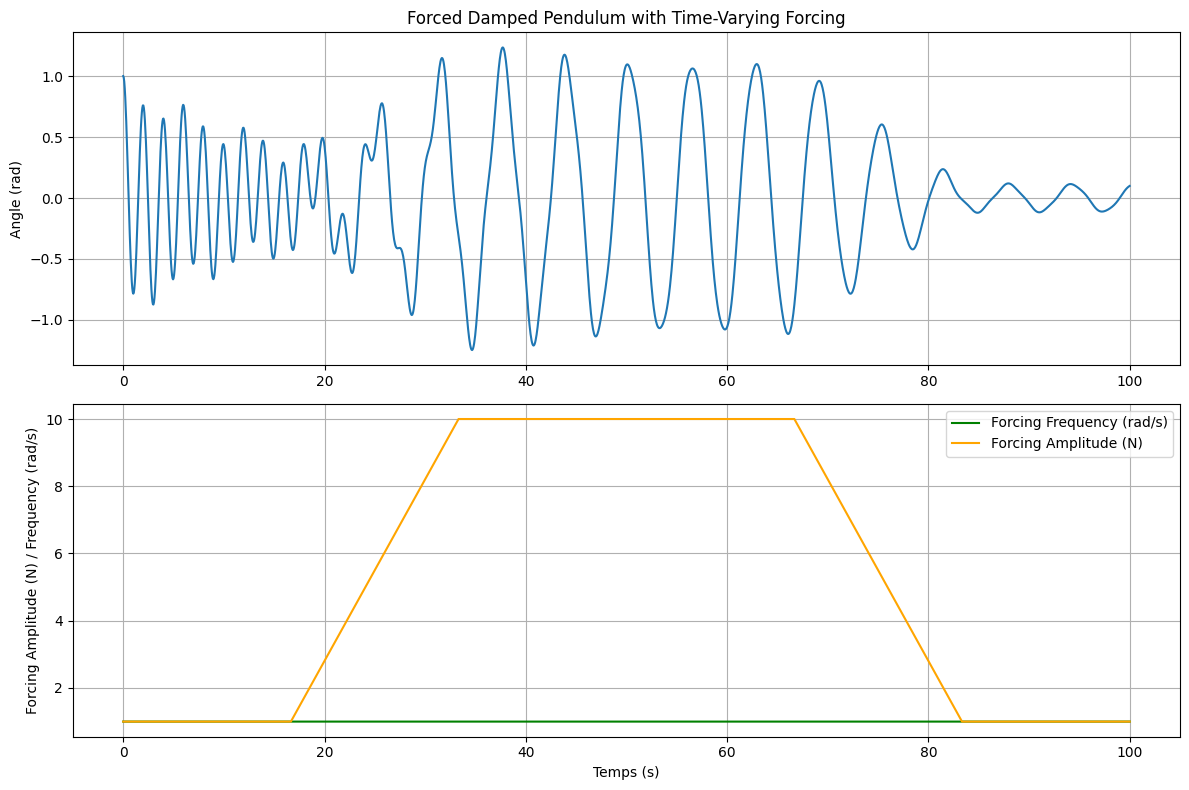

In [9]:
# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(t, y)
ax1.set_ylabel('Angle (rad)')
ax1.set_title('Forced Damped Pendulum with Time-Varying Forcing')
ax1.grid(True)

ax2.plot(t, omega_array, color='green', label='Forcing Frequency (rad/s)')
ax2.plot(t, A_array, color='orange', label='Forcing Amplitude (N)')
ax2.set_ylabel('Forcing Amplitude (N) / Frequency (rad/s)')
ax2.set_xlabel('Temps (s)')
ax2.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

#### Create Dataset of various parameters for differents forcing

* A: fixed
* theta0: fixed
* omega0: fixed
* kapa: varying randomly
* beta: varying randomly
* omega_forcing: choosen among a discret number


In [11]:
def create_dataset(
        N_sample: int, 
        maxtime: float, 
        n_timestep: int, 
        kapa_range: tuple, 
        beta_range: tuple, 
        trapezoidal_forcing_values: dict,
        A_value: float | None = 1.0,
        omega_value: float | None = 1.0,
        theta0: float = 0.5, 
        omega0: float = 0.0
    ):
    """
    Create a dataset of synthetic damped forced pendulum data with varying parameters.

    Args:
        N_sample (int): Number of samples to generate.
        maxtime (float): Maximum time for the simulation.
        n_timestep (int): Number of time steps in the simulation.
        kapa_range (tuple): Tuple defining the range of spring constants (min, max).
        beta_range (tuple): Tuple defining the range of damping coefficients (min, max).
        trapezoidal_forcing_values (dict): dictionary of args for the forcing parameters.
        A_value (float or None): Amplitude of the forcing term (constant or variable).
        omega_forcing_values (float or None): Pulsation of the forcing term (constant or variable).

    Parameters:
        theta0 (float): Initial angle (in radians).
        omega0 (float): Initial angular velocity (in radians per second).

    Returns:
        list: List of dictionaries containing parameters and corresponding angle arrays.
    """
    assert (A_value is not None) ^ (omega_value is not None), "Either A_value or omega_value must be provided as constant."

    dataset = []
    t = np.linspace(0, maxtime, n_timestep)

    for _ in tqdm(range(N_sample)):
        # Choose forcing frequency parameters
        trap_start, trap_end = 1.0, 0.0
        while trap_start >= trap_end:
            trap_start = np.random.uniform(*trapezoidal_forcing_values["start_value"])
            trap_end = np.random.uniform(*trapezoidal_forcing_values["end_value"])
        proportions = [np.random.uniform(*trapezoidal_forcing_values["proportions"][a]) for a in range(4)]
        trap_forcing_values_sampled = {
            "start_value": trap_start,
            "end_value": trap_end,
            "proportions": proportions
        }
        # Randomly choose a forcing frequency from the provided values
        if omega_value is not None:
            A_forcing = create_trapezoidal_forcing(t=t, N_time_steps=n_timestep, **trap_forcing_values_sampled)
            omega_forcing = np.ones(n_timestep) * omega_value
        else:
            omega_forcing = create_trapezoidal_forcing(t=t, N_time_steps=n_timestep, **trap_forcing_values_sampled)
            A_forcing = np.ones(n_timestep) * A_value

        # Randomly sample kapa and beta within their respective ranges
        kapa = np.random.uniform(*kapa_range)
        beta = np.random.uniform(*beta_range)

        # Create the synthetic data
        y = create_synthetic_damped_forced_pendulum(A_forcing, omega_forcing, beta, kapa, theta0, omega0, t)

        # Store the parameters and the resulting angle array
        sample = {
            'kapa': kapa,
            'beta': beta,
            'forcing': omega_forcing if omega_value is None else A_forcing,
            'time': t,
            'angle': y
        }
        
        dataset.append(sample)
    
    return dataset

In [12]:
eps = 1/13
trapezoid_range = [(1/6-eps, 1/6+eps), (1/3-eps, 1/3+eps), (2/3-eps, 2/3+eps), (5/6-eps, 5/6+eps)]
trapezoidal_forcing_ranges = {
    "start_value": (0.5, 2.0),
    "end_value": (1.0, 6.0),
    "proportions": trapezoid_range,
}

beta_range = config.BETA_RANGE
kapa_range = config.KAPA_RANGE
N_samples = config.N_SAMPLES
N_time_steps = config.TIMESTEPS
max_time = config.MAXTIME

dataset = create_dataset(
    N_sample=N_samples,
    maxtime=max_time,
    n_timestep=N_time_steps,
    kapa_range=kapa_range,
    beta_range=beta_range,
    trapezoidal_forcing_values=trapezoidal_forcing_ranges,
    A_value=config.A_VALUE,
    omega_value=config.OMEGA_VALUE,
    theta0=config.THETA0,
    omega0=config.OMEGA0
)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 99/20000 [00:03<12:22, 26.79it/s]


KeyboardInterrupt: 

In [14]:
len(dataset)

20000

In [13]:
path = config.DIR_RAW_DATA / "synthetic_damped_forced_pendulum_dataset.npy"

#np.save(path, dataset)
dataset = np.load(path, allow_pickle=True)

In [14]:
dataset[0]

{'kapa': 1.6326304372798894,
 'beta': 4.3977926559872085,
 'forcing': array([1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.06181018, 1.06181018, 1.06181018, 1.06181018,
        1.06181018, 1.22359505, 1.38537993, 1.5471648 , 1.70894968,
        1.87073455, 2.03251942, 2.1943043 , 2.35608917, 2.51787405,
        2.67965892, 2.8414438 , 3.00322867, 3.16501354, 3.32679842,
        3.48858329, 3.65036817, 3.81215304, 3.97393792, 4.13572279,
        4.29750766, 4.45929254, 4.62107741, 4.78286229, 4.94464716,
        5.10643203, 5.26821691, 5.43000178, 5.5

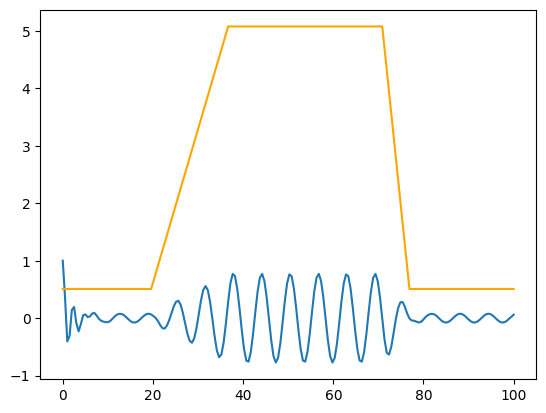

In [15]:
id_to_plot = 9
plt.plot(dataset[id_to_plot]['time'], dataset[id_to_plot]['angle'])
plt.plot(dataset[id_to_plot]['time'], dataset[id_to_plot]['forcing'], color='orange')
plt.show()

#### Create dataloader for SciNet

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

In [17]:
class forced_pendulum_dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        observations = torch.tensor(sample['angle'], dtype=torch.float32)
        questions = torch.tensor(sample['forcing'], dtype=torch.float32)
        params = torch.tensor([sample['kapa'], sample['beta']], dtype=torch.float32)
        return observations, questions, params

In [18]:
split_ratio = config.SPLIT_RATIO  # Train, Validation, Test

train_size = int(split_ratio[0] * len(dataset))
val_size = int(split_ratio[1] * len(dataset))
test_size = len(dataset) - train_size - val_size

Dataset_custom = forced_pendulum_dataset(dataset)

train_dataset, val_dataset, test_dataset = random_split(Dataset_custom, [train_size, val_size, test_size])

In [19]:
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print("Types of datasets:", type(train_dataset), type(val_dataset), type(test_dataset))

Train size: 14000
Validation size: 3000
Test size: 3000
Types of datasets: <class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'> <class 'torch.utils.data.dataset.Subset'>


In [20]:
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE_TRAIN, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE_EVAL, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE_EVAL, shuffle=True)

#### Scinet network

In [31]:
class SciNetEncoder(nn.Module):
    def __init__(self, 
                 input_size: int = 1000, 
                 latent_size: int = 3, 
                 hidden_sizes: list[int] = [128, 64]
                 ) -> None:
        super().__init__()
        self.input_sizes = [input_size] + hidden_sizes[:-1]
        self.output_sizes = hidden_sizes
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))]
        )
        self.mean_layer = nn.Linear(hidden_sizes[-1], latent_size)
        self.logvar_layer = nn.Linear(hidden_sizes[-1], latent_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor]:
        for layer, activation in zip(self.layers, self.activations):
            x = activation(layer(x))
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar
    

class QuestionDecoder(nn.Module):
    def __init__(self, 
                 latent_size: int = 3, 
                 question_size: int = 1000, 
                 output_size: int = 1000, 
                 hidden_sizes: list = [128, 128]
                 ) -> None:
        super().__init__()
        self.input_sizes = [latent_size + question_size] + hidden_sizes
        self.output_sizes = hidden_sizes + [output_size]
        self.layers = nn.ModuleList(
            [nn.Linear(in_size, out_size) for in_size, out_size in zip(self.input_sizes, self.output_sizes)]
        )
        self.activations = nn.ModuleList(
            [nn.ELU() for _ in range(len(hidden_sizes))] + [nn.Identity()]
        )

    def forward(self, z: torch.Tensor, question: torch.Tensor) -> torch.Tensor:
        z = torch.cat([z, question], dim=-1)
        for layer, activation in zip(self.layers, self.activations):
            z = activation(layer(z))
        return z


class PendulumNet(nn.Module):
    def __init__(self, 
                 input_size: int = 1000, 
                 enc_hidden_sizes: list[int] = [128, 64], 
                 latent_size: int = 3, 
                 question_size: int = 1000,
                 dec_hidden_sizes: list[int] = [128, 128], 
                 output_size: int = 1000
                 ) -> None:
        super().__init__()
        self.encoder = SciNetEncoder(input_size=input_size, latent_size=latent_size, hidden_sizes=enc_hidden_sizes)
        self.decoder = QuestionDecoder(latent_size=latent_size, question_size=question_size, output_size=output_size, hidden_sizes=dec_hidden_sizes)


    def forward(self, x, question):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        possible_answer = self.decoder(z, question)
        return possible_answer, mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std


In [32]:
def scinet_loss_forced_pendulum(
        possible_answer: torch.Tensor, 
        a_corr: torch.Tensor, 
        mean: torch.Tensor, 
        logvar: torch.Tensor, 
        beta: float = 0.003
        ) -> torch.Tensor:

    recon_loss = torch.nn.MSELoss()(possible_answer.squeeze(), a_corr.squeeze())
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), dim=1).mean()
    return recon_loss + beta * kld_loss, kld_loss, recon_loss

#### Train scinet

In [33]:
from physical_parameters_SciNet.ml_tools.train_callbacks import EarlyStopping, GradientClipping, LRScheduling

In [34]:
def train_scinet(
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        model: torch.nn.Module, 
        optimizer: torch.optim.Optimizer, 
        num_epochs: int = 150, 
        kld_beta: float = 0.001, 
        early_stopper: EarlyStopping = None, 
        gradient_clipper: GradientClipping = None, 
        lr_scheduler: LRScheduling = None,
        device: torch.device = torch.device('cpu')
        ) -> None:

    torch.cuda.empty_cache()
    model.to(device)
    print("------training on {}-------\n".format(device))
    history = {'train_loss': [], 'valid_loss': []}
    print(f"{'Epoch':<20} ||| {'Train Loss':<15} ||| {'KLD Loss':<12} {'Recon Loss':<12} ||||||| {'Valid Loss':<15}")

    # Training
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        kld_loss, recon_loss = 0.0, 0.0
        for observations, questions, _ in tqdm(train_loader, desc="Training", leave=False):
            a_corr = observations.clone()
            observations = observations.to(device)
            questions = questions.to(device)
            a_corr = a_corr.to(device)

            optimizer.zero_grad()
            possible_answer, mean, logvar = model(observations, questions)
            loss, l_kld, l_recon = scinet_loss_forced_pendulum(possible_answer, a_corr, mean, logvar, beta=kld_beta)
            loss.backward()
            if gradient_clipper is not None:
                gradient_clipper.on_backward_end(model)
            optimizer.step()

            train_loss += loss.item() * observations.size(0)
            kld_loss += l_kld.item() * observations.size(0)
            recon_loss += l_recon.item() * observations.size(0)
        train_loss /= len(train_loader.dataset)
        kld_loss /= len(train_loader.dataset)
        recon_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # Evaluation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for observations, questions, _ in tqdm(valid_loader, desc="Validation", leave=False):
                a_corr = observations.clone()
                observations = observations.to(device)
                questions = questions.to(device)
                a_corr = a_corr.to(device)

                possible_answer, mean, logvar = model(observations, questions)
                loss = scinet_loss_forced_pendulum(possible_answer, a_corr, mean, logvar, beta=kld_beta)[0]
                valid_loss += loss.item() * observations.size(0)
        
        valid_loss /= len(valid_loader.dataset)
        history['valid_loss'].append(valid_loss)

        print(f"{f'{epoch+1}/{num_epochs}':<20}  |  {train_loss:<15.6f}  |  {kld_loss:<12.6f} {recon_loss:<12.6f}    |    {valid_loss:<15.6f}")

        if early_stopper is not None:
            if early_stopper.check_stop(valid_loss, model):
                print(f"Early stopping at epoch {epoch + 1} with loss {valid_loss:.4f}")
                print(f"Restoring best weights for model.")
                early_stopper.restore_best_weights(model)
                break

        if lr_scheduler is not None:
            lr_scheduler.step(valid_loss)

        path = config.DIR_PARAMS_CHECKPOINTS / "pendulum_scinet_checkpointed.pth"
        torch.save(model.state_dict(), path)

        del observations, questions, a_corr, possible_answer, mean, logvar, loss, l_kld, l_recon
        torch.cuda.empty_cache()
        gc.collect()
    
    return history

In [35]:
def plot_history(history_train: list, history_valid: list) -> None:
    plt.figure(figsize=(8, 5))
    plt.plot(history_train, 'b-', linewidth=2, label='Train Loss')
    plt.plot(history_valid, 'r-', linewidth=2, label='Valid Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    path = config.DIR_FIGURES / "training_validation_loss.png"
    plt.savefig(path)
    return None

In [36]:
device = torch.device("cuda:1")
device

device(type='cuda', index=1)

In [37]:
### SCINET architecture
TIMESTEPS = config.TIMESTEPS  # 200
M_INPUT_SIZE = TIMESTEPS
M_ENC_HIDDEN_SIZES = config.M_ENC_HIDDEN_SIZES  # [500, 100] # [500, 100, 100]
M_LATENT_SIZE = config.M_LATENT_SIZE  # 3
M_QUESTION_SIZE = TIMESTEPS
M_DEC_HIDDEN_SIZES = config.M_DEC_HIDDEN_SIZES  # [500, 500] # [200, 200, 300]
M_OUTPUT_SIZE = TIMESTEPS

### Hyperparameters
BATCH_SIZE_TRAIN = config.BATCH_SIZE_TRAIN  # 50
BATCH_SIZE_VALID = config.BATCH_SIZE_EVAL  # 50
FIRST_LEARNING_RATE = config.FIRST_LEARNING_RATE  # 5e-4
WEIGHT_DECAY = config.WEIGHT_DECAY  # 1e-6
KLD_BETA = config.KLD_BETA  # 0.0003

### Train parameters
NUM_EPOCHS = config.NUM_EPOCHS  # 150
ES_PATIENCE = config.ES_PATIENCE  # 12
ES_MIN_DELTA = config.ES_MIN_DELTA  # 5e-4
GC_MAX_NORM = config.GC_MAX_NORM  # 1.0
LRS_FACTOR = config.LRS_FACTOR  # 0.66
LRS_PATIENCE = config.LRS_PATIENCE  # 5
LRS_MIN_LR = config.LRS_MIN_LR  # 1e-7
LRS_MIN_DELTA = config.LRS_MIN_DELTA  # 1e-4

In [38]:
pendulum_net = PendulumNet(
    input_size=M_INPUT_SIZE,
    enc_hidden_sizes=M_ENC_HIDDEN_SIZES,
    latent_size=M_LATENT_SIZE,
    question_size=M_QUESTION_SIZE,
    dec_hidden_sizes=M_DEC_HIDDEN_SIZES,
    output_size=M_OUTPUT_SIZE
)
optimizer = torch.optim.Adam(pendulum_net.parameters(), lr=FIRST_LEARNING_RATE, weight_decay=WEIGHT_DECAY)
early_stopper = EarlyStopping(patience=ES_PATIENCE, min_delta=ES_MIN_DELTA)
gradient_clipper = GradientClipping(max_norm=GC_MAX_NORM)
lr_scheduler = LRScheduling(optimizer, factor=LRS_FACTOR, patience=LRS_PATIENCE, min_lr=LRS_MIN_LR, min_delta=LRS_MIN_DELTA)

In [40]:
history = train_scinet(
    train_loader, 
    valid_loader, 
    pendulum_net, 
    optimizer, 
    num_epochs=NUM_EPOCHS, 
    kld_beta=KLD_BETA, 
    early_stopper=early_stopper, 
    gradient_clipper=gradient_clipper, 
    lr_scheduler=lr_scheduler,
    device=device
)

path = config.DIR_MODEL_PARAMS / (config.BEST_MODEL_NAME + ".pth")
torch.save(pendulum_net.state_dict(), path)

------training on cuda:1-------

Epoch                ||| Train Loss      ||| KLD Loss     Recon Loss   ||||||| Valid Loss     


1/150                 |  0.006884         |  3.967261     0.002917        |    0.006331       


2/150                 |  0.006667         |  3.926964     0.002740        |    0.006340       


3/150                 |  0.006642         |  3.867944     0.002774        |    0.006147       


4/150                 |  0.006494         |  3.841568     0.002653        |    0.006549       


5/150                 |  0.006457         |  3.792311     0.002665        |    0.005926       


6/150                 |  0.006264         |  3.741737     0.002522        |    0.006038       


7/150                 |  0.006337         |  3.711039     0.002626        |    0.006223       


8/150                 |  0.006199         |  3.673836     0.002526        |    0.005713       


9/150                 |  0.006099         |  3.622711     0.002476        |    0.005801       


10/150                |  0.006077         |  3.586414     0.002490        |    0.005599       


11/150                |  0.005948         |  3.548991     0.002399        |    0.005932       


12/150                |  0.005921         |  3.493584     0.002428        |    0.005494       


13/150                |  0.005791         |  3.473988     0.002317        |    0.005357       


14/150                |  0.005741         |  3.426724     0.002314        |    0.005511       


15/150                |  0.005664         |  3.392880     0.002271        |    0.005302       


16/150                |  0.005622         |  3.373653     0.002249        |    0.005215       


17/150                |  0.005561         |  3.325340     0.002235        |    0.005203       


18/150                |  0.005582         |  3.292748     0.002289        |    0.005204       


19/150                |  0.005409         |  3.280718     0.002129        |    0.005210       


20/150                |  0.005444         |  3.271226     0.002173        |    0.005323       


21/150                |  0.005377         |  3.236748     0.002140        |    0.005701       


22/150                |  0.005320         |  3.220400     0.002100        |    0.005077       


23/150                |  0.005306         |  3.216178     0.002090        |    0.005070       


24/150                |  0.005250         |  3.195140     0.002055        |    0.004856       


25/150                |  0.005222         |  3.182325     0.002039        |    0.004886       


26/150                |  0.005205         |  3.185453     0.002019        |    0.004874       


27/150                |  0.005298         |  3.172113     0.002126        |    0.004868       


28/150                |  0.005119         |  3.152073     0.001967        |    0.004965       


29/150                |  0.005207         |  3.164744     0.002042        |    0.004964       


30/150                |  0.005114         |  3.152603     0.001962        |    0.004923       
Reduced learning rate from 5.00e-05 to 3.30e-05


31/150                |  0.005047         |  3.150988     0.001896        |    0.004842       


32/150                |  0.004961         |  3.148660     0.001812        |    0.004766       


33/150                |  0.004982         |  3.128384     0.001853        |    0.004786       


34/150                |  0.004960         |  3.137296     0.001823        |    0.004665       


35/150                |  0.004958         |  3.137144     0.001821        |    0.004792       


36/150                |  0.004919         |  3.122538     0.001797        |    0.004889       


37/150                |  0.004925         |  3.117779     0.001807        |    0.004948       


38/150                |  0.004858         |  3.100326     0.001757        |    0.004651       


39/150                |  0.004889         |  3.126413     0.001763        |    0.004664       


40/150                |  0.004865         |  3.101705     0.001763        |    0.004679       


41/150                |  0.004947         |  3.103156     0.001844        |    0.004627       


42/150                |  0.004841         |  3.102555     0.001738        |    0.004796       


43/150                |  0.004835         |  3.107367     0.001728        |    0.004580       


44/150                |  0.004936         |  3.123286     0.001813        |    0.004727       


45/150                |  0.004828         |  3.091365     0.001737        |    0.004589       


46/150                |  0.004818         |  3.080736     0.001737        |    0.004643       


47/150                |  0.004813         |  3.093670     0.001720        |    0.004690       


48/150                |  0.004825         |  3.091595     0.001734        |    0.004637       


49/150                |  0.004791         |  3.091228     0.001700        |    0.004637       
Reduced learning rate from 3.30e-05 to 2.18e-05


50/150                |  0.004699         |  3.077186     0.001622        |    0.004557       


51/150                |  0.004691         |  3.084504     0.001607        |    0.004604       


52/150                |  0.004752         |  3.095791     0.001656        |    0.004521       


53/150                |  0.004736         |  3.102676     0.001633        |    0.004887       


54/150                |  0.004719         |  3.093264     0.001626        |    0.004588       


55/150                |  0.004747         |  3.100888     0.001646        |    0.004778       


56/150                |  0.004653         |  3.078140     0.001575        |    0.004691       


57/150                |  0.004704         |  3.069107     0.001634        |    0.004518       


58/150                |  0.004654         |  3.076890     0.001577        |    0.004605       
Reduced learning rate from 2.18e-05 to 1.44e-05


59/150                |  0.004633         |  3.067552     0.001565        |    0.004542       


60/150                |  0.004614         |  3.061834     0.001552        |    0.004468       


61/150                |  0.004611         |  3.074175     0.001537        |    0.004709       


62/150                |  0.004633         |  3.069723     0.001564        |    0.004491       


63/150                |  0.004610         |  3.069615     0.001541        |    0.004508       


64/150                |  0.004612         |  3.070178     0.001541        |    0.004479       


65/150                |  0.004587         |  3.049018     0.001538        |    0.004529       


66/150                |  0.004643         |  3.063431     0.001580        |    0.004514       
Reduced learning rate from 1.44e-05 to 9.49e-06


67/150                |  0.004595         |  3.063566     0.001531        |    0.004472       


68/150                |  0.004556         |  3.054925     0.001501        |    0.004553       


69/150                |  0.004585         |  3.057681     0.001527        |    0.004416       


70/150                |  0.004573         |  3.060738     0.001512        |    0.004437       


71/150                |  0.004558         |  3.054817     0.001503        |    0.004515       


72/150                |  0.004557         |  3.053542     0.001504        |    0.004443       


73/150                |  0.004568         |  3.058989     0.001509        |    0.004497       


74/150                |  0.004547         |  3.058811     0.001488        |    0.004497       


75/150                |  0.004539         |  3.045660     0.001493        |    0.004436       
Reduced learning rate from 9.49e-06 to 6.26e-06


76/150                |  0.004533         |  3.039302     0.001494        |    0.004375       


77/150                |  0.004526         |  3.043751     0.001482        |    0.004426       


78/150                |  0.004516         |  3.040238     0.001476        |    0.004443       


79/150                |  0.004512         |  3.036882     0.001475        |    0.004493       


80/150                |  0.004528         |  3.038451     0.001490        |    0.004404       


81/150                |  0.004534         |  3.044081     0.001490        |    0.004454       
Early stopping at epoch 81 with loss 0.0045
Restoring best weights for model.


In [ ]:
# Load best model
# pendulum_net.load_state_dict(torch.load(path))

/tmp/ipykernel_3566204/3102714156.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pendulum_net.load_state_dict(torch.load(path))


UnpicklingError: unpickling stack underflow

In [29]:
# print(pendulum_net)

In [30]:
# model_weight = torch.load(path)
# print(model_weight.keys())

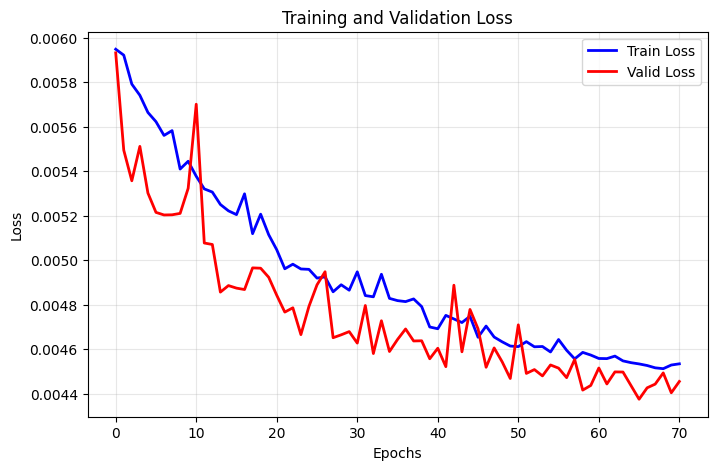

In [41]:
plot_history(history['train_loss'][10:], history['valid_loss'][10:])

#### Test pendulumenet

In [49]:
sample_idx = np.random.choice(config.TEST_SIZE)
sample_idx

1792

In [50]:
# Choose a sample from the test set
pendulum_net.eval()
with torch.no_grad():
    observations, questions, params = test_dataset[sample_idx]
    observations = observations.unsqueeze(0).to(device)  # Add batch dimension
    questions = questions.unsqueeze(0).to(device)

    possible_answer, mean, logvar = pendulum_net(observations, questions)
    possible_answer = possible_answer.squeeze().cpu().numpy()  # Remove batch dimension and move to CPU
    observations = observations.squeeze().cpu().numpy()
    questions = questions.squeeze().cpu().numpy()
    L, b = params.numpy()

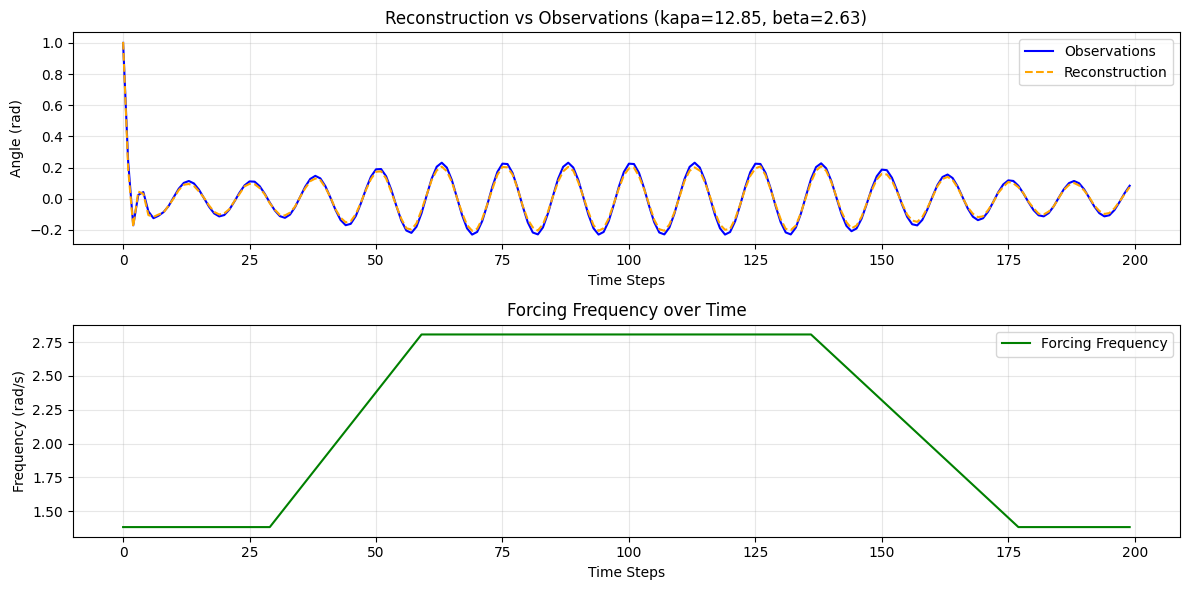

In [51]:
# Plot the results
# Fistly, plot the reconstruction and the observations
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(observations, label='Observations', color='blue')
plt.plot(possible_answer, label='Reconstruction', color='orange', linestyle='--')
plt.title(f'Reconstruction vs Observations (kapa={L:.2f}, beta={b:.2f})')
plt.xlabel('Time Steps')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(2, 1, 2)
plt.plot(questions, label='Forcing Frequency', color='green')
plt.title('Forcing Frequency over Time')
plt.xlabel('Time Steps')
plt.ylabel('Frequency (rad/s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

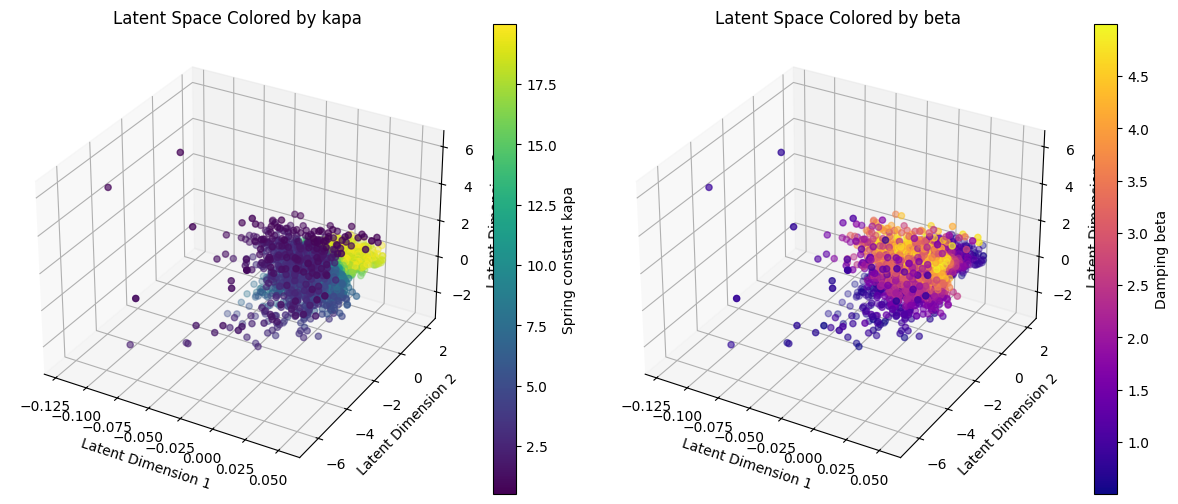

In [45]:
## Secondly, plot the latent space
all_means = []
all_params = []
pendulum_net.eval()
with torch.no_grad():
    for observations, questions, params in test_loader:
        observations = observations.to(device)
        questions = questions.to(device)
        mean, _ = pendulum_net.encoder(observations)
        all_means.append(mean.cpu().numpy())
        all_params.append(params.numpy())
all_means = np.concatenate(all_means, axis=0)
all_params = np.concatenate(all_params, axis=0)
L_values = all_params[:, 0]
b_values = all_params[:, 1]
latent_1 = all_means[:, 0]
latent_2 = all_means[:, 1]
latent_3 = all_means[:, 2]

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(131, projection='3d')
p = ax.scatter(latent_1, latent_2, latent_3, c=L_values, cmap='viridis')
fig.colorbar(p, ax=ax, label='Spring constant kapa')
ax.set_title('Latent Space Colored by kapa')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

ax = fig.add_subplot(132, projection='3d')
p = ax.scatter(latent_1, latent_2, latent_3, c=b_values, cmap='plasma')
fig.colorbar(p, ax=ax, label='Damping beta')
ax.set_title('Latent Space Colored by beta')
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

plt.tight_layout()
plt.show()

In [ ]:
print(pendulum_net)